In [246]:
# lot of code is taken from vehicle detection lesson as it was coded during the quiz.
# importing libraries involved for the project.

In [247]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from skimage.feature import hog
%matplotlib inline

In [248]:
#Features extraction
#Here we define functions for features extraction (HOG, binned color and color histogram features). The functions are based on code from the Udacity's lectures.

In [249]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True: # Call with two outputs if vis==True to visualize the HOG
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      # Otherwise call with one output
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(16, 16)):
    return cv2.resize(img, size).ravel() 

# Define a function to compute color histogram features 
def color_hist(img, nbins=32):
    ch1 = np.histogram(img[:,:,0], bins=nbins, range=(0, 256))[0]#We need only the histogram, no bins edges
    ch2 = np.histogram(img[:,:,1], bins=nbins, range=(0, 256))[0]
    ch3 = np.histogram(img[:,:,2], bins=nbins, range=(0, 256))[0]
    hist = np.hstack((ch1, ch2, ch3))
    return hist

In [250]:
# Define a function to extract features from a list of images
def img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,image_o):
    file_features = []
    if spatial_feat == True:
        spatial_features = bin_spatial(image_o, size=spatial_size)
        #print 'spat', spatial_features.shape
        file_features.append(spatial_features)
    if hist_feat == True:
         # Apply color_hist()
        hist_features = color_hist(image_o, nbins=hist_bins)
        #print 'hist', hist_features.shape
        file_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if color_space == 'GRAY':
            hog_features = get_hog_features(feature_image, orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        elif hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
        else:
            feature_image = cv2.cvtColor(feature_image, cv2.COLOR_LUV2RGB)
            feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
            hog_features = get_hog_features(feature_image[:,:], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                #print 'hog', hog_features.shape
            # Append the new feature vector to the features list
        file_features.append(hog_features)
    return file_features

def extract_features(imgs, color_space='YUV', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file_p in imgs:
        file_features = []
        image = cv2.imread(file_p) # Read in each imageone by one
        image_o = image
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            elif color_space == 'GRAY':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else: feature_image = np.copy(image)      
        file_features = img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,image_o)
        features.append(np.concatenate(file_features))
        feature_image=cv2.flip(feature_image,1) # Augment the dataset with flipped images
        file_features = img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,image_o)
        features.append(np.concatenate(file_features))
    return features # Return list of feature vectors

In [251]:
# Read in cars and notcars
images = glob.glob('*vehicles/*/*')
cars = []
notcars = []
for image in images:
    if 'non' in image:
        notcars.append(image)
    else:
        cars.append(image)
print(len(cars))
print(len(notcars))

8792
8968


In [253]:
# Define parameters for feature extraction
# using rbf kernel as accuracy is better than linear kernel for the usecase

from sklearn.svm import SVC
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print('Car samples: ', len(car_features))
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print('Notcar samples: ', len(notcar_features))
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

X_scaler = StandardScaler().fit(X) # Fit a per-column scaler
scaled_X = X_scaler.transform(X) # Apply the scaler to X

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)))) # Define the labels vector

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=22)

print('Using:',orient,'orientations', pix_per_cell, 'Color space' , color_space,
    'pixels per cell', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
svc = SVC() # Use a linear SVC 
t=time.time() # Check the training time for the SVC
svc.fit(X_train, y_train) # Train the classifier
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) # Check the score of the SVC


Car samples:  17584
Notcar samples:  17936
Using: 9 orientations 8 Color space YUV pixels per cell 2 cells per block
Feature vector length: 2628
16944.64 Seconds to train SVC...
Test Accuracy of SVC =  0.997


In [254]:
#implementation of sliding window inspired by udacity lecture on vehicle detection.

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes on an image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img) # Make a copy of the image
    for bbox in bboxes: # Iterate through the bounding boxes
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [255]:
def single_img_features(img, color_space='YUV', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif color_space == 'GRAY':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(img, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(img, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if color_space == 'GRAY':
            hog_features = get_hog_features(feature_image, orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        elif hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)

26.51 Seconds to process test images


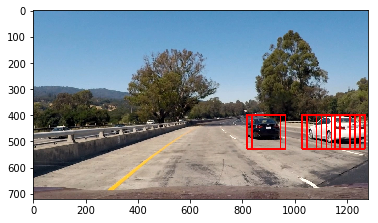

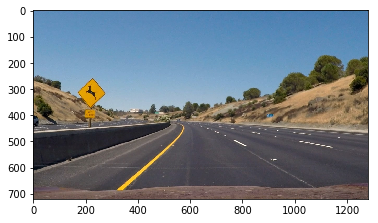

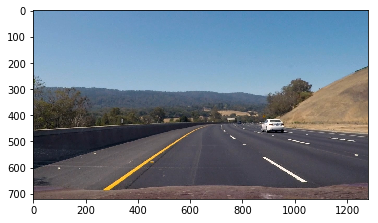

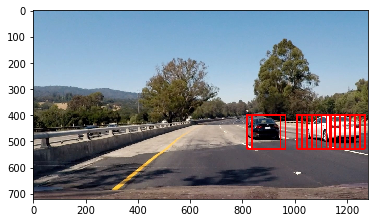

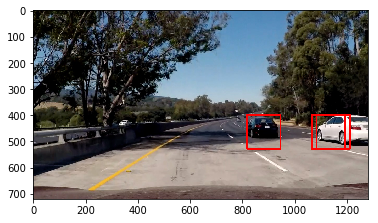

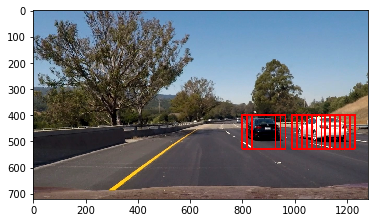

In [256]:
# detecting vehicle and adding boxes.
for image_p in glob.glob('test_images/test*.jpg'):
    image = cv2.imread(image_p)
    draw_image = np.copy(image)
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 640], 
                    xy_window=(128, 128), xy_overlap=(0.85, 0.85))
    hot_windows = []
    hot_windows += (search_in_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    show_img(window_img)


In [257]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_in_windows(img, windows, clf, scaler, color_space='YUV', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=8, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))

        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# A function to show an image
def show_img(img):
    if len(img.shape)==3: #Color BGR image
        plt.figure()
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else: # Grayscale image
        plt.figure()
        plt.imshow(img, cmap='gray')

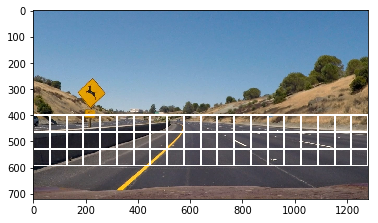

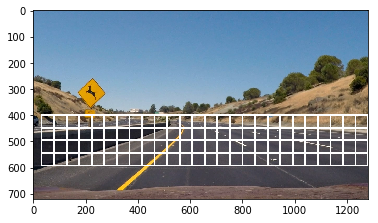

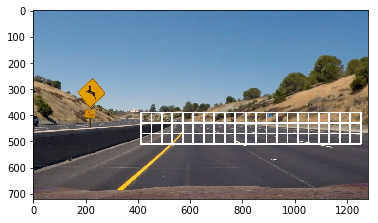

In [258]:

image = cv2.imread('test_images/test2.jpg')
#windows = slide_window(image, x_start_stop=[930, None], y_start_stop=[420, 650], 
#                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
#windows += slide_window(image, x_start_stop=[0, 350], y_start_stop=[420, 650], 
#                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
#window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6) 
#windows = slide_window(image, x_start_stop=[400, 880], y_start_stop=[400, 470], 
#                    xy_window=(52, 52), xy_overlap=(0.75, 0.75))
#window_img = draw_boxes(window_img, windows, color=(255, 0, 0), thick=6)                    
#show_img(window_img)
sw_x_limits = [
    [None, None],
    [34, None],
    [410, 1280]
]

sw_y_limits = [
    [402, 642],
    [402, 602],
    [388, 542]
]

sw_window_size = [
    (128, 128),
    (96, 96),
    (80, 80)
]

sw_overlap = [
    (0.5, 0.5),
    (0.5, 0.5),
    (0.5, 0.5)
]

# create sliding windows of different combinations
windows = slide_window(image, x_start_stop=sw_x_limits[0], y_start_stop=sw_y_limits[0], 
                    xy_window=sw_window_size[0], xy_overlap=sw_overlap[0])

windows2 = slide_window(image, x_start_stop=sw_x_limits[1], y_start_stop=sw_y_limits[1], 
                    xy_window=sw_window_size[1], xy_overlap=sw_overlap[1])

windows3 = slide_window(image, x_start_stop=sw_x_limits[2], y_start_stop=sw_y_limits[2], 
                    xy_window=sw_window_size[2], xy_overlap=sw_overlap[2])

window_img = draw_boxes(image, windows, color=(255, 255, 255), thick=6) 
show_img(window_img)
window_img = draw_boxes(image, windows2, color=(255, 255, 255), thick=6) 
show_img(window_img)
window_img = draw_boxes(image, windows3, color=(255, 255, 255), thick=6) 
show_img(window_img)

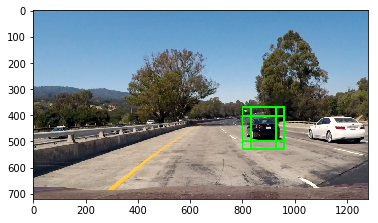

In [259]:
image = cv2.imread('test_images/test1.jpg')
track = (880, 450)
w_size = 80
window_img = 0 
windows = slide_window(image, x_start_stop=[track[0]-w_size,track[0]+w_size], 
                       y_start_stop=[track[1]-w_size,track[1]+w_size], 
                       xy_window=(128, 128), xy_overlap=(0.75, 0.75))
window_img = draw_boxes(image, windows, color=(0, 255, 0), thick=6)
windows = slide_window(image, x_start_stop=[track[0]-w_size,track[0]+w_size], 
                       y_start_stop=[track[1]-int(w_size),track[1]+int(w_size)], 
                       xy_window=(52, 52), xy_overlap=(0.75, 0.75))
#window_img = draw_boxes(window_img, windows, color=(255, 0, 0), thick=6)                    
show_img(window_img)

In [260]:
def convert_color(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
def search_in_windows(img, windows, clf, scaler, color_space='YUV', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64), interpolation=cv2.INTER_AREA)      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows



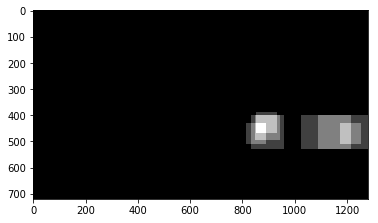

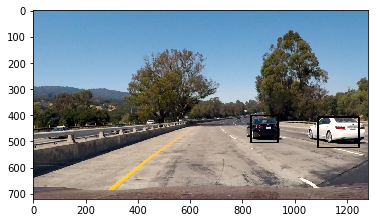

In [261]:
sw_x_limits = [
    [None, None],
    [32, None],
    [412, 1280]
]

sw_y_limits = [
    [400, 640],
    [400, 600],
    [390, 540]
]

sw_window_size = [
    (128, 128),
    (96, 96),
    (80, 80)
]

sw_overlap = [
    (0.5, 0.5),
    (0.5, 0.5),
    (0.5, 0.5)
]

def get_heat_map(image, box_list):
    """
    To find heat map of positive windows.
    Args:
    1. image (numpy.array): image
    Returns:
    1. heatmap (numpy.array) grayscale image of the same size as input image
    """

    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    # Iterate through list of bboxes
    for box in box_list:
        # Add += 1 for all pixels inside  box
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap

def get_hot_boxes (image):
    """
    This function applies sliding windows to images and finds all boxes. Also returns image with all boxes are drawn
    Args:
    1 . image (numpy.array): image
    Returns:
    1 . hot_windows(list), image_with_hot_windows_drawn(numpy.array)
    """
    img_copy = np.copy (image)
    all_positive_windows = []

    # for all combination of defined sliding window size we find hot windows
    for x_limits, y_limits, window_size, overlap in zip (sw_x_limits, sw_y_limits, sw_window_size, sw_overlap):

        windows = slide_window(
            img_copy,
            x_start_stop=x_limits,
            y_start_stop=y_limits,
            xy_window=window_size,
            xy_overlap=overlap
        )

        pos_windows = search_in_windows(image, windows, svc, X_scaler, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)

        all_positive_windows.extend (pos_windows)

        img_copy = draw_boxes(img_copy, pos_windows, color=(255, 0, 0), thick=5)

    return all_positive_windows, img_copy

def is_overlap(box, box_dict,b):
    # to determine what boxes to be merged and not
    # Thank you, davin
    # http://math.stackexchange.com/questions/99565/simplest-way-to-calculate-the-intersect-area-of-two-rectangles
    x11 = box_dict[b]['avg_box'][0][0]
    y11 = box_dict[b]['avg_box'][0][1]
    x12 = box_dict[b]['avg_box'][1][0]
    y12 = box_dict[b]['avg_box'][1][1]
    x21 = box [0][0]
    y21 = box [0][1]
    x22 = box [1][0]
    y22 = box [1][1]

    x_overlap = max(0, min(x12,x22) - max(x11,x21))
    y_overlap = max(0, min(y12,y22) - max(y11,y21))

    area1 = (x12 - x11) * (y12 - y11)
    area2 = (x22 - x21) * (y22 - y21)
    intersection = x_overlap * y_overlap;

    if (
        intersection >= 0.25 * area1 or
        intersection >= 0.25 * area2
    ):
        #print(box_dict[b]['avg_box'][0][0],box_dict[b]['avg_box'][0][1],box_dict[b]['avg_box'][1][0],box_dict[b]['avg_box'][1][1])
        return True
    else:
        return False

# to join boxes and come with a smooth box after merging
def join(positive_boxes,b,box_dict):
  joined = False
  #print(len(positive_boxes))
  for i in positive_boxes:
    #print(i)
    if is_overlap(i,box_dict,b):
      #print(i)
      positive_boxes.remove(i)
      box_dict[b]['boxes'].append(i)
      box_dict[b]['detected_count']+=1
      box_dict[b]['avg_box'][0][0] = min(box_dict[b]['avg_box'][0][0],i[0][0])
      box_dict[b]['avg_box'][0][1] = min(box_dict[b]['avg_box'][0][1],i[0][1])
      box_dict[b]['avg_box'][1][0] = max(box_dict[b]['avg_box'][1][0],i[1][0])
      box_dict[b]['avg_box'][1][1] = max(box_dict[b]['avg_box'][1][1],i[1][1])
      joined = True
  #print(len(positive_boxes))
  return joined

def get_avg_box(i,box_dict):
    """
    this is average box representation.
    This box has average center of all boxes and have
    size of 2 standard deviation by x and y coordinates of its points
    """
    if len(box_dict[i]['boxes']) > 1:
        center = np.average (np.average (box_dict[i]['boxes'], axis=1), axis=0).astype(np.int32).tolist()

        # getting all x and y coordinates of
        # all corners of joined boxes separately
        xs = np.array(box_dict[i]['boxes']) [:,:,0]
        ys = np.array(box_dict[i]['boxes']) [:,:,1]

        half_width = int(np.std (xs))
        half_height = int(np.std (ys))
        return (
            (
                center[0] - half_width,
                center[1] - half_height
            ), (
                center[0] + half_width,
                center[1] + half_height
            ))
    else:
        return box_dict[i]['boxes'][0]

def average_boxes(positive_boxes,overlap):
  all_boxes = []
  avg_boxes = []
  box_dict = {}
  #print(len(positive_boxes))
  while len(positive_boxes) >0:
    b = positive_boxes.pop(0)
    #print(b)
    box_dict[b] = {}
    box_dict[b]['avg_box'] = [list(p) for p in b]
    box_dict[b]['detected_count'] =1
    box_dict[b]['boxes'] = [b]
    while join(positive_boxes,b,box_dict):
      pass
    avg_boxes.append(b)
  #print(len(avg_boxes))
  for i in avg_boxes:
    if box_dict[i]['detected_count'] >= overlap:
      all_boxes.append(get_avg_box(i,box_dict))
  return all_boxes
hot_boxes, image_with_hot_boxes = get_hot_boxes(image)
heat_map = get_heat_map (image, hot_boxes)
show_img(heat_map)
avg_boxes = average_boxes (hot_boxes, 2)
#print(avg_boxes)
image_with_boxes = draw_boxes(image, avg_boxes, color=(0, 0, 1), thick=4)
show_img(image_with_boxes)

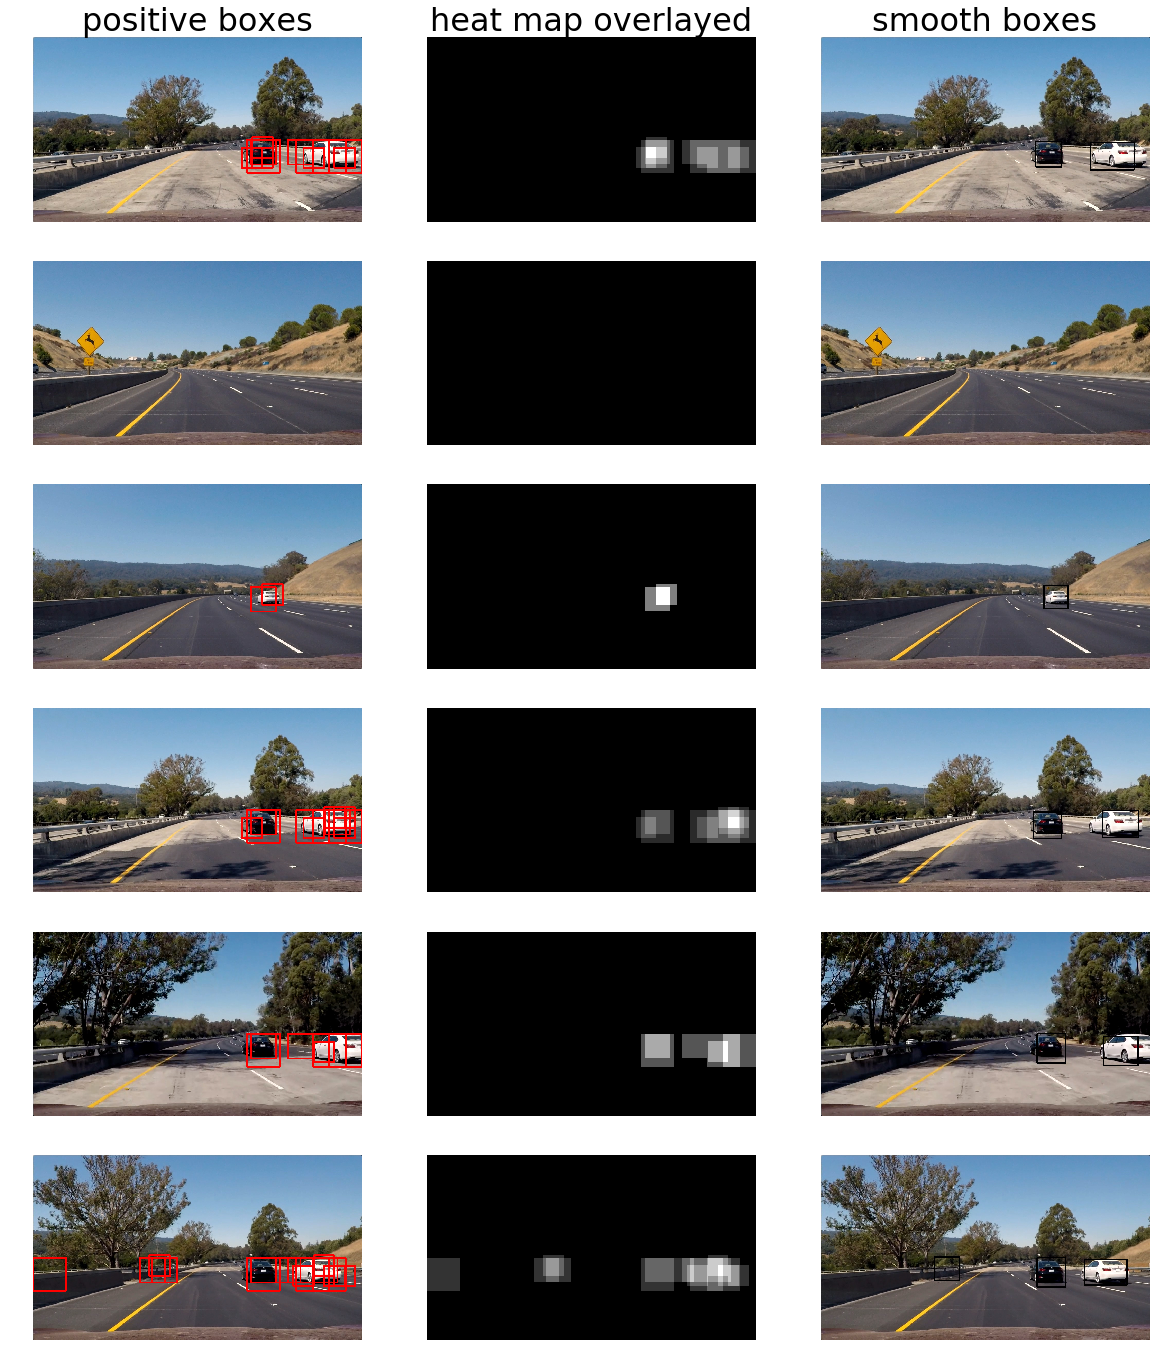

In [262]:
def show_tabular (images, table_size, fig_size = (10, 10), cmap=None, titles=None):
    sizex = table_size [0]
    sizey = table_size [1]
    fig, imtable = plt.subplots (sizey, sizex, figsize = fig_size, squeeze=False)
    for j in range (sizey):
        for i in range (sizex):
            im_idx = i + j*sizex
            if (isinstance(cmap, (list, tuple))):
                imtable [j][i].imshow (images[im_idx], cmap=cmap[i])
            else:
                im = images[im_idx]
                if len(im.shape) == 3:
                    imtable [j][i].imshow (im)
                else:
                    imtable [j][i].imshow (im, cmap='gray')
            imtable [j][i].axis('off')
            if not titles is None:
                imtable [j][i].set_title (titles [im_idx], fontsize=32)

    plt.show ()
    
test_images = []
test_images_titles = []

for impath in glob.glob('test_images/test*.jpg'):
    image = mpimg.imread(impath)
    # hot boxes
    hot_boxes, image_with_hot_boxes = get_hot_boxes (image)
    # heat map
    heat_map = get_heat_map (image, hot_boxes)
    
    # average boxes
    avg_boxes = average_boxes (hot_boxes, 2)
    image_with_boxes = draw_boxes(image, avg_boxes, color=(0, 0, 1), thick=4)
    test_images.append (image_with_hot_boxes)
    test_images.append (heat_map)
    test_images.append (image_with_boxes)
    
    test_images_titles.extend (['', '', ''])
    
test_images_titles [0] = 'positive boxes'
test_images_titles [1] = 'heat map overlayed'
test_images_titles [2] = 'smooth boxes'

show_tabular (test_images, (3, 6), fig_size=(20, 24), titles=test_images_titles)


In [265]:
class PositiveBoxesQueue ():
    """Class for accumulation of hot boxes from last 10 frames
    """
    def __init__ (self):
        self.queue_max_len = 10 # number items to store
        self.last_boxes = []

    def put_hot_boxes (self, boxes):
        """Put frame positive boxes
        """
        if (len(self.last_boxes) > self.queue_max_len):
            tmp = self.last_boxes.pop (0)
        
        self.last_boxes.append (boxes)
        
    def get_hot_boxes (self):
        """Get last 10 frames hot boxes
        """
        b = []
        for boxes in self.last_boxes:
            b.extend (boxes)
        return b

last_hot_boxes = PositiveBoxesQueue ()
    
def process_image (image_orig):    
    image_orig = np.copy (image_orig)
    image = image_orig.astype(np.float32)/255
    # accumulating positive boxes over 10 last frames
    hot_boxes, image_with_hot_boxes = get_hot_boxes (image_orig)
    last_hot_boxes.put_hot_boxes (hot_boxes)
    hot_boxes = last_hot_boxes.get_hot_boxes ()
    
    # calculating average boxes and use strong ones
    # need to tune strength on particular classifer
    avg_boxes = average_boxes(hot_boxes, 20)
    image_with_boxes = draw_boxes(image_orig, avg_boxes, color=(0, 0, 255), thick=4)

    return image_with_boxes

In [266]:
from moviepy.editor import VideoFileClip

def process_video (input_path, output_path):
    clip = VideoFileClip (input_path)
    result = clip.fl_image (process_image)
    result.write_videofile (output_path)

process_video ('project_video.mp4', 'project_video_result8.mp4')


[MoviePy] >>>> Building video project_video_result8.mp4
[MoviePy] Writing audio in project_video_result8TEMP_MPY_wvf_snd.mp3


100%|██████████| 1112/1112 [00:01<00:00, 1098.14it/s]

[MoviePy] Done.
[MoviePy] Writing video project_video_result8.mp4



100%|█████████▉| 1260/1261 [44:31<00:02,  2.06s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result8.mp4 

